In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
def repair_fraction(time, m, beta, theta):
    return (1 - np.exp(-(beta * time)**m)) * theta

In [3]:
def repair_fraction_over_time(to_time, m, beta, theta):
    return np.asarray([repair_fraction(t, m, beta, theta) for t in range(to_time)])

In [4]:
example_params = np.asarray([
    [1.5, 1/20., 0.95],
    [2, 1/35., 0.9],
    [2.5, 1/45., 0.85],
])
to_time = 140

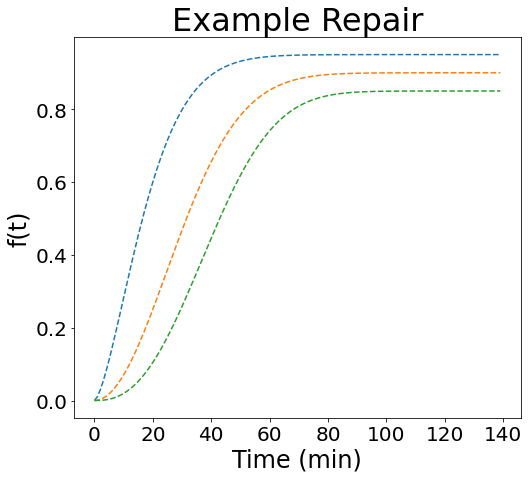

In [5]:
plt.figure(figsize=(8, 7))
plt.plot(
    repair_fraction_over_time(
        to_time, 
        example_params[:, 0],
        example_params[:, 1],
        example_params[:, 2]
    ),
    linestyle='--'
)
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('f(t)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Example Repair', fontsize=32)
plt.show()

In [6]:
import pymc3 as pm
import theano.tensor as tt
from theano import scan as tscan
import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
n_points = 100
obs_fraction = repair_fraction_over_time(to_time, *example_params[0])
# sample data points
observation = np.asarray([
    np.random.binomial(1, p=np.minimum(np.maximum(p, 0), 1), size=n_points)
    for p in obs_fraction
]).reshape(-1)
time_points = np.repeat(np.arange(to_time), n_points)

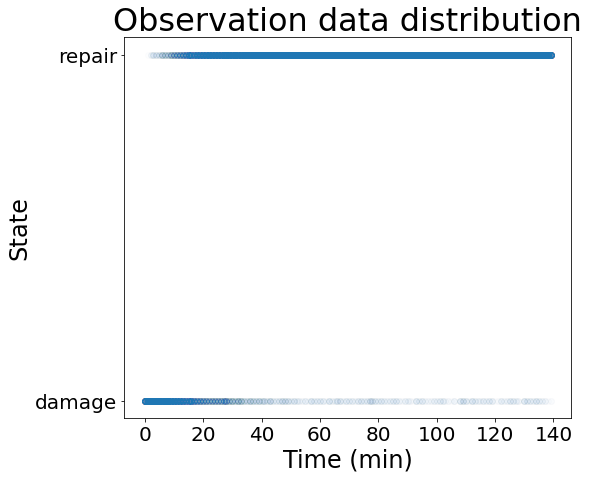

In [8]:
plt.figure(figsize=(8, 7))
plt.scatter(time_points, observation, alpha=.01)
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('State', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks([0, 1], ['damage', 'repair'], fontsize=20)
plt.title('Observation data distribution', fontsize=32)
plt.show()

In [9]:
def twod_growth(time, n, g, m, theta, shape=4*np.pi):
    beta = ((shape * n * g**(m-1)) / m)**(1./m)
    return repair_fraction(time, m, beta, theta)

In [10]:
def twod_growth_over_time(to_time, n, g, m, theta, shape=4*np.pi):
    return [twod_growth(t, n, g, m, theta, shape) for t in range(to_time)]

In [11]:
m = example_params[0, 0]  # m from observation
theta = example_params[0, 2] # theta from observation
n_samples = 2000
with pm.Model() as cellmd_model:
    n = pm.Exponential('n', lam=1., testval=1.)
    g = pm.Exponential('g', lam=1., testval=1.)
    shape = pm.Bound(pm.Normal, lower=0)('shape', mu=4*np.pi, sigma=1, testval=4*np.pi)
    beta = ((shape * n * g**(m-1)) / m)**(1./m)
    p = pm.Deterministic('p', repair_fraction(time_points, m, beta, theta))
    obs = pm.Bernoulli('obs', p, observed=observation)
    
    step = pm.Metropolis()
    cellmd_trace = pm.sample(n_samples, step=step, chains=5, return_inferencedata=False)

Multiprocess sampling (5 chains in 4 jobs)
CompoundStep
>Metropolis: [shape]
>Metropolis: [g]
>Metropolis: [n]


/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effecti

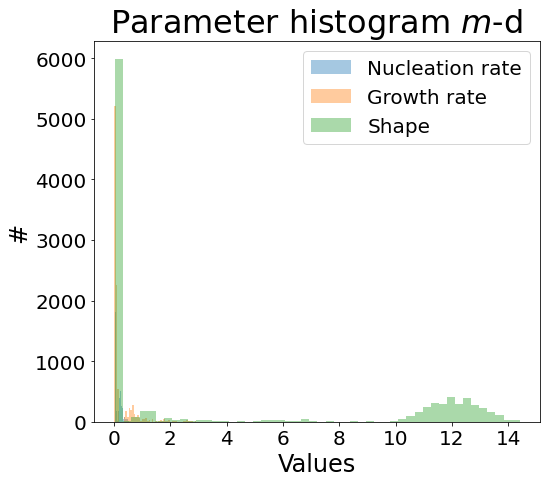

In [12]:
plt.figure(figsize=(8, 7))
plt.hist(cellmd_trace['n'], bins=50, alpha=.4, label='Nucleation rate')
plt.hist(cellmd_trace['g'], bins=50, alpha=.4, label='Growth rate')
plt.hist(cellmd_trace['shape'], bins=50, alpha=.4, label='Shape')
plt.xlabel('Values', fontsize=24)
plt.ylabel('#', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Parameter histogram $m$-d', fontsize=32)
plt.legend(loc='upper right', fontsize=20)
plt.show()

In [13]:
print(
    'Mean n=%.2f, mean g=%.2f, mean shape=%.2f' % 
    (np.mean(cellmd_trace['n']), np.mean(cellmd_trace['g']), np.mean(cellmd_trace['shape']))
)

Mean n=0.18, mean g=0.22, mean shape=4.13


In [14]:
repair_md = twod_growth_over_time(
    to_time, 
    cellmd_trace['n'],
    cellmd_trace['g'], 
    m, 
    theta,
    cellmd_trace['shape']
)

In [15]:
mean_repair_md = np.mean(repair_md, axis=1)
std_repair_md = np.std(repair_md, axis=1)

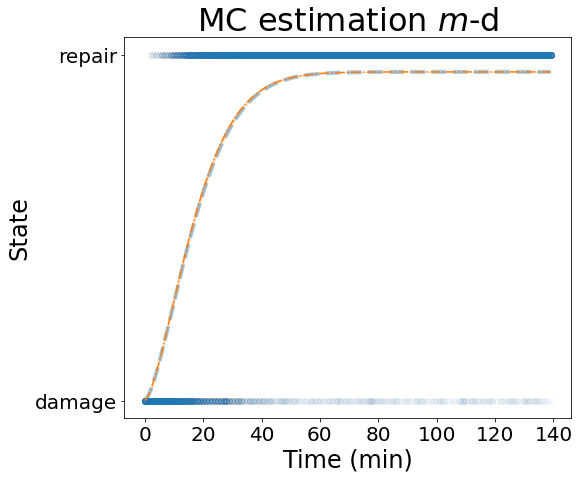

In [16]:
plt.figure(figsize=(8, 7))
plt.plot(
    repair_fraction_over_time(to_time, *example_params[0]),
    linestyle='--', 
    color='tab:blue', 
    label='KJMA',
    linewidth=4,
    alpha=.4
)
plt.plot(mean_repair_md, linestyle='-.', color='tab:orange', label='Estimation')
plt.fill_between(
    np.arange(to_time),
    mean_repair_md - std_repair_md,
    mean_repair_md + std_repair_md,
    color='tab:orange',
    alpha=.2
)
plt.scatter(time_points, observation, alpha=.01, color='tab:blue')
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('State', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks([0, 1], ['damage', 'repair'], fontsize=20)
plt.title('MC estimation $m$-d', fontsize=32)
plt.show()

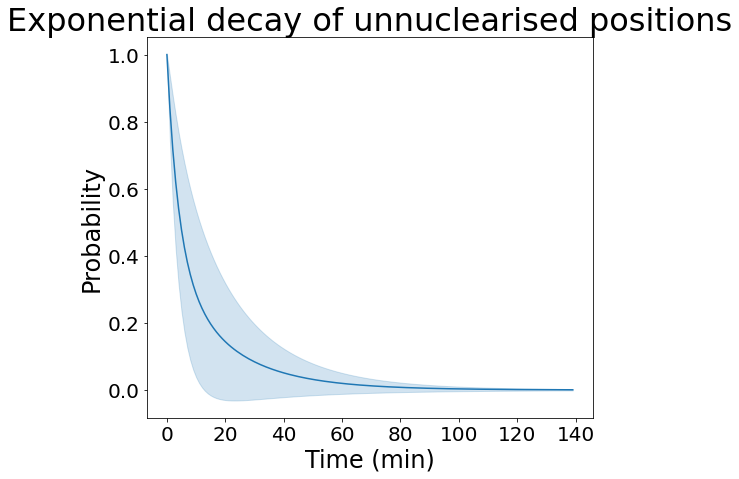

In [17]:
plt.figure(figsize=(8, 7))
ensemble_decay = [np.exp(-cellmd_trace['n'] * t) for t in range(to_time)]
mean_decay = np.mean(ensemble_decay, axis=1)
std_decay = np.std(ensemble_decay, axis=1)
plt.plot(mean_decay, color='tab:blue')
plt.fill_between(
    np.arange(to_time),
    mean_decay - std_decay,
    mean_decay + std_decay,
    color='tab:blue',
    alpha=.2
)

plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('Probability', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Exponential decay of unnuclearised positions', fontsize=32)
plt.show()

In [18]:
import cv2
import imageio

In [19]:
class Nucleation:
    def __init__(self, x, y, m, G, shape):
        self.x = int(x)
        self.y = int(y)
        self.m = m 
        self.G = G
        self.shape = shape
        self.radius = 0
    
    def get_coordinates(self):
        return np.asarray([self.x, self.y])
    
    def update_radius(self, scaling=1):
        self.radius += self.G**self.m * scaling
        
    def calc_circular_radius(self):
        surface = self.shape * self.radius
        return np.sqrt(surface / (4 * np.pi))
        
    def calculate_surface(self):
        surface = self.shape * self.radius
        square_approx = np.sqrt(surface)
        row, col = np.indices((int(np.round(square_approx)), int(np.round(square_approx))), dtype='float')
        row += self.x / 2
        col += self.y / 2
        x_idc, y_idc = [], []
        for i, j in zip(row.reshape(-1), col.reshape(-1)):
            if np.linalg.norm(np.abs(self.get_coordinates() - np.asarray([i, j]))) < 0.5 + self.radius:
                x_idc.append(i)
                y_idc.append(j)

        return np.round(x_idc).astype('int'), np.round(y_idc).astype('int')

In [20]:
def simulation(state, nucleation_list, m, n, G, shape):
    scaling = 4. / (shape * G**m)
    # Growth
    for nucleation in nucleation_list:
        nucleation.update_radius(scaling=scaling)
        circ_radius = int(nucleation.calc_circular_radius())
        state = cv2.circle(state, nucleation.get_coordinates(), circ_radius, 1., -1)
        
    nucleation_candidates = np.random.binomial(1, p=n_mean, size=state.shape) == 1
    new_nucleation = zip(*np.where(np.logical_and(nucleation_candidates, state != 1)))
    for x, y in new_nucleation:
        nucleation_list.append(Nucleation(x, y, m, G, shape))
        
    return state, nucleation_list

In [23]:
state = np.zeros((500, 500))
nucleation_list = []
n_idx = np.argmin(cellmd_trace['n'])
n_mean = cellmd_trace['n'][n_idx]
g_mean = cellmd_trace['g'][n_idx]
shape_mean = cellmd_trace['shape'][n_idx]

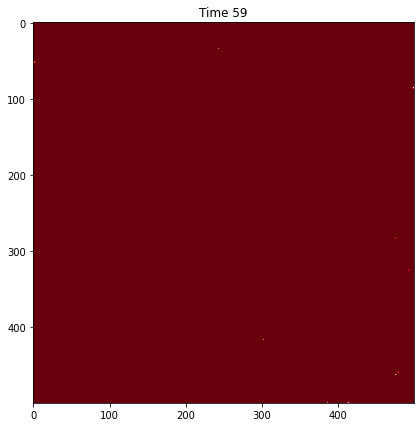

In [24]:
import time
from IPython import display
%matplotlib inline

do_sort = False
save_gif = False
norm = Normalize(vmin=0, vmax=1)
plt.figure(figsize=(8, 7))
ax = plt.gca()
state_list = []
sim_rep_frac = []
for t in np.arange(60):
    state, nucleation_list = simulation(
        state, 
        nucleation_list, 
        example_params[0, 0],
        n_mean,
        g_mean, 
        shape_mean
    )
    
    try:
        ax.clear()
        
        if do_sort:
            y_sort = np.argsort(state).reshape(-1)
            x_sort = np.repeat(np.arange(state.shape[0]), state.shape[1]).reshape(-1)
            ax.imshow(state[x_sort, y_sort].reshape(state.shape), cmap='Reds', norm=norm)
            state_list.append(state[x_sort, y_sort].reshape(state.shape))
        else:
            ax.imshow(state, cmap='Reds', norm=norm)
            state_list.append(state.astype('uint8').copy() * 255)
        ax.set_title('Time %s' % t)
        fig = plt.gcf()
        fig.canvas.draw()
        
        uncoloured = np.sum(state == 0)
        sim_rep_frac.append((1 - uncoloured / state.size) * example_params[0, 2])
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        break
    
if save_gif:
    save_name = 'sorted' if do_sort else 'random'
    imageio.mimsave('figures/gif/%s_500.gif' % save_name, state_list, format='GIF-PIL', fps=10)

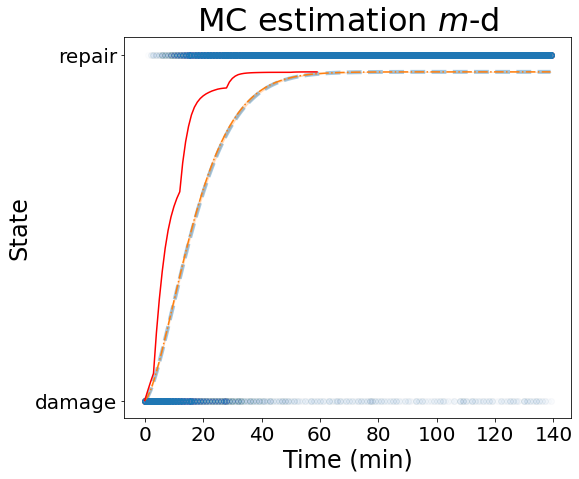

In [25]:
plt.figure(figsize=(8, 7))
plt.plot(
    repair_fraction_over_time(to_time, *example_params[0]),
    linestyle='--', 
    color='tab:blue', 
    label='KJMA',
    linewidth=4,
    alpha=.4
)
plt.plot(mean_repair_md, linestyle='-.', color='tab:orange', label='Estimation')
plt.fill_between(
    np.arange(to_time),
    mean_repair_md - std_repair_md,
    mean_repair_md + std_repair_md,
    color='tab:orange',
    alpha=.2
)
plt.plot(np.asarray(sim_rep_frac), color='red')
plt.scatter(time_points, observation, alpha=.01, color='tab:blue')
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('State', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks([0, 1], ['damage', 'repair'], fontsize=20)
plt.title('MC estimation $m$-d', fontsize=32)
plt.show()